# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned_test/'
selections = [
              'emu', 
              'mumu',  'mutau', 'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 
            'L', 'sigma_tt', 'sigma_z', 'sigma_w', 'k_fake', 
            'eff_e', 'eff_mu', 'eff_tau', 
            'trigger_e', 'trigger_mu',
            'pileup', 'escale_e', 'escale_mu', 'escale_tau', 
            'jes', 'jer', 'btag', 'mistag',
            'fsr', 'isr', 'tune', 'hdamp', 'qcd', 'pdf'
           ]

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[1, 2])

In [3]:
# generate Asimov dataset
toy_data = dict()
for b in fit_data._bins:
    toy_data[b] = dict()
    for selection in selections:
        if b == 0 and selection in ['e4j', 'mu4j']:
            continue
            
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates[b]['signal']
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[b][selection] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection not in ['mu4j', 'mutau']:
                continue

            bg_template = templates[b][bg][0]
            toy_data[b][selection] += bg_template

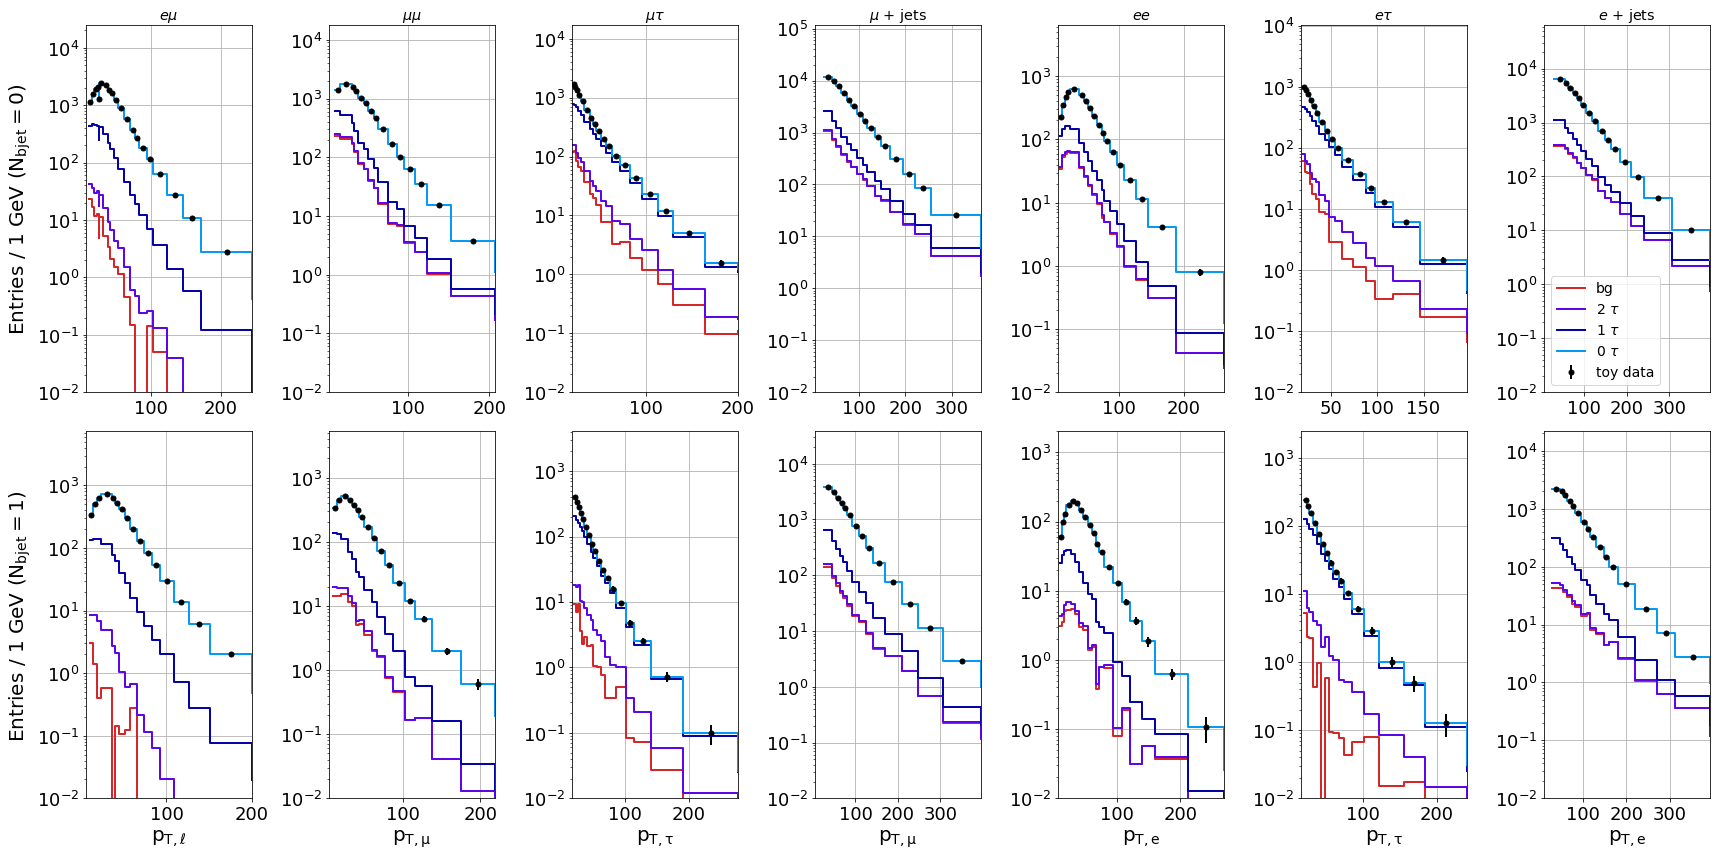

In [4]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for j, b in enumerate(fit_data._bins):
        if b == 0 and selection in ['e4j', 'mu4j']:
            continue
            
        bins = s_data[b]['bins']
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[j][i]
        data = toy_data[b][selection]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data[b]['signal']
        bg = s_data[b]['wjets'][0] + s_data[b]['zjets'][0]
        if selection in ['mu4j', 'mutau']:
            bg += s_data[b]['fakes'][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if j == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 0$)')
        elif j == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif j == 2:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [5]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 24*[1., ] # niceify this: nuisance parameters are initialized to 1
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [6]:
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,0.879
B_mu,0.749
B_tau,2.099
B_h,0.375
L,1.910
sigma_tt,2.500
sigma_z,5.251
sigma_w,10.663
k_fake,9.347
eff_e,0.857


<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7fb58675da20>>

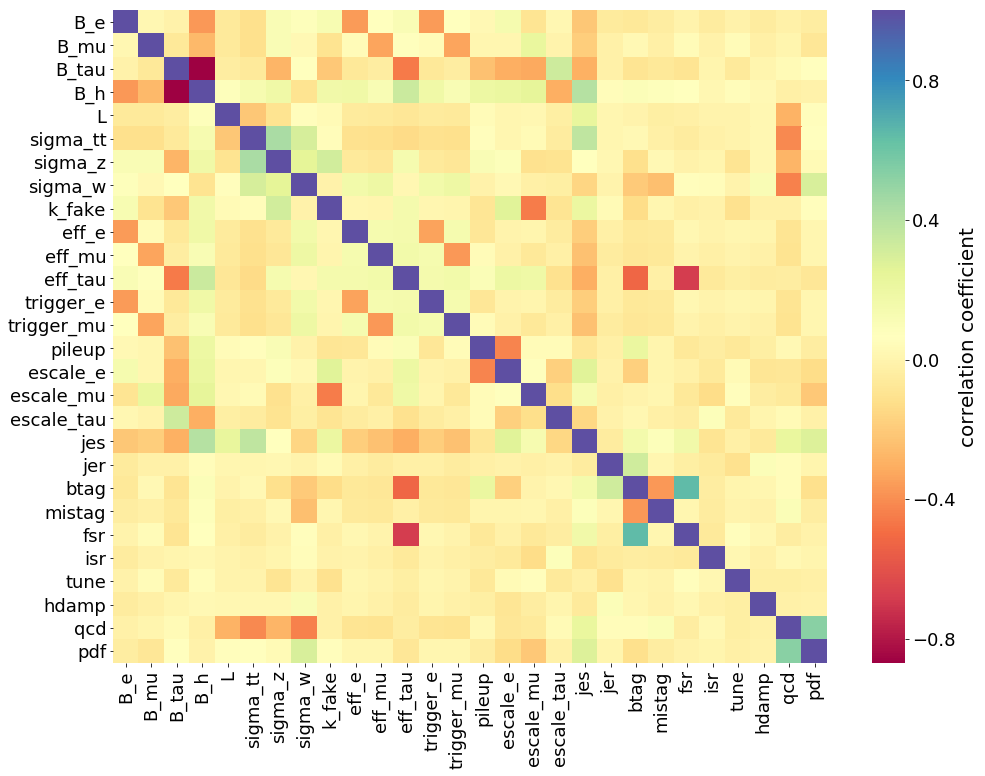

In [7]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr.to_csv('data/cov_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16, 12))
sns.heatmap(df_corr, cmap='Spectral', ax=ax, cbar_kws={'label': r'correlation coefficient'})
ax.set

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [8]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

In [9]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,trigger_e,trigger_mu,pileup,escale_e,escale_mu,escale_tau,jes,jer,btag,mistag,fsr,isr,tune,hdamp,qcd,pdf
stat only,0.137,0.109,0.609,0.092,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
L,0.877,0.747,2.098,0.374,0.000,2.441,5.226,10.648,9.341,0.855,0.825,1.635,0.855,0.825,51.787,10.258,9.209,15.913,28.933,77.973,6.908,97.152,7.297,11.415,8.706,8.775,21.871,69.821
sigma_tt,0.873,0.744,2.095,0.372,1.866,0.000,4.712,10.162,9.337,0.852,0.821,1.626,0.852,0.821,51.739,10.258,9.205,15.905,27.497,77.970,6.906,97.164,7.292,11.414,8.706,8.775,20.816,69.807
sigma_z,0.873,0.744,2.013,0.369,1.901,2.243,0.000,10.319,8.873,0.855,0.824,1.624,0.855,0.824,51.490,10.216,9.156,15.848,29.637,77.966,6.864,97.165,7.300,11.415,8.669,8.775,21.949,69.897
sigma_w,0.876,0.748,2.095,0.373,1.908,2.382,5.082,0.000,9.346,0.846,0.811,1.640,0.846,0.811,51.822,10.255,9.206,15.912,29.330,77.975,6.763,94.292,7.288,11.402,8.706,8.723,20.606,66.866
k_fake,0.872,0.745,2.053,0.369,1.909,2.497,4.985,10.662,0.000,0.857,0.827,1.622,0.857,0.827,51.627,9.888,8.215,15.856,29.059,77.941,6.852,97.194,7.298,11.415,8.656,8.775,22.847,69.823
eff_e,0.820,0.748,2.095,0.369,1.907,2.486,5.241,10.523,9.346,0.000,0.818,1.622,0.805,0.818,51.685,10.258,9.210,15.904,29.207,77.946,6.890,97.007,7.298,11.416,8.705,8.776,22.759,69.926
eff_mu,0.877,0.705,2.098,0.372,1.907,2.483,5.235,10.457,9.347,0.848,0.000,1.617,0.848,0.769,51.775,10.256,9.185,15.917,28.836,77.894,6.888,96.943,7.300,11.411,8.706,8.775,22.745,69.926
eff_tau,0.874,0.746,1.870,0.352,1.905,2.477,5.200,10.661,9.242,0.847,0.815,0.000,0.847,0.815,51.528,10.057,9.047,15.828,28.346,77.945,5.880,97.161,5.333,11.392,8.701,8.768,22.831,69.712
trigger_e,0.820,0.748,2.095,0.369,1.907,2.486,5.241,10.523,9.346,0.805,0.818,1.622,0.000,0.818,51.685,10.258,9.210,15.904,29.207,77.946,6.890,97.007,7.298,11.416,8.705,8.776,22.759,69.926


In [10]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)

100%|██████████| 24/24 [00:00<00:00, 3046.25it/s]


,B_e,B_mu,B_tau,B_h
stat only,0.137,0.109,0.609,0.092
L,0.056,0.048,0.087,0.031
sigma_tt,0.102,0.082,0.130,0.050
sigma_z,0.102,0.082,0.598,0.066
sigma_w,0.074,0.017,0.143,0.037
k_fake,0.110,0.071,0.440,0.064
eff_e,0.318,0.029,0.138,0.068
eff_mu,0.058,0.251,0.085,0.044
eff_tau,0.098,0.056,0.954,0.128
trigger_e,0.318,0.029,0.138,0.068
